我们要完成一次 Berlekamp 译码算法的仿真，参数如下：

- 信道类型：
    - 加性高斯白噪声 ( Additional Gaussian White Noise， AWGN )
- 调制方式：
    - BPSK
- 编码方式
    - RS ( 255, 239, 17 )
    - RS ( 255, 223, 33 )
    - Raw BPSK
- $E_b / N_0$
    - RS ( 255, 239, 17 ) : 4.0 ~ 7.4 dB
    - RS ( 255, 223, 33 ) : 4.0 ~ 6.6 dB 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import RS255

In [2]:
def EbN02Amp(EbN0db, N0, num_n, num_k):
    EbN0 = 10 ** (EbN0db / 10.0)
    Eb = EbN0 * N0
    return np.sqrt(2 * Eb / num_n * num_k)

为了保证 $Eb/N0$ 换算成星座映射的幅值是正确的，首先对BPSK的误码率进行仿真分析。

In [3]:
sim_psk_db = np.arange(0, 10.5, 0.5)
N0 = 1.0
amp = EbN02Amp(sim_psk_db, N0, 1, 1)
ber_psk = np.zeros(amp.shape)
bit_num = 10000000

for index, value in enumerate(amp):
    sequence_received = (np.random.randn(bit_num) * np.sqrt(N0) - value) > 0
    error_num = np.sum(sequence_received)
    ber_psk[index] = error_num / bit_num
    

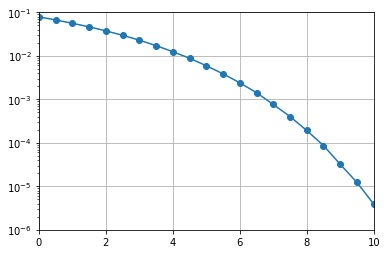

In [4]:
plt.semilogy(sim_psk_db, ber_psk, marker="o")
plt.grid(True)
plt.xlim(0, 10)
plt.ylim(1e-6, 1e-1)
plt.show()

可以看到误码率为 1e-5 的时，$E_b / N_0$ 大概为 9.6 dB。

之后对 RS(255, 255, 239, 17) 的误符号率和误块率进行统计。

In [47]:
db_255_239_17 = np.arange(4.4, 7.6, 0.2)
seq_num_255_239_17 = [10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 50000, 200000, 800000]
amp = EbN02Amp(db_255_239_17, N0, 255, 239)
SER_255_239_17 = np.zeros(db_255_239_17.shape)
BLER_255_239_17 = np.zeros(db_255_239_17.shape)
for index, value in enumerate(amp):
    symbol_num = 0
    block_num = 0
    se_num = 0
    ble_num = 0
    print("db = ", db_255_239_17[index])
    for k in range(seq_num_255_239_17[index]):
        symbol_seq = np.zeros(255, dtype=np.uint16)
        rec_symbol_seq = np.zeros(255, dtype=np.uint16)
        bit_seq = np.random.randn(255 * 8) * np.sqrt(N0) - value
        for i in range(255):
            symbol = int(0)
            for j in range(8):
                symbol += (1 << j if bit_seq[i * 8 + j] > 0 else 0)
            symbol_seq[i] = symbol
        RS255.berlekamp_decoder(8, symbol_seq, rec_symbol_seq)
        symbol_error_flag = rec_symbol_seq > 0
        block_se_num = np.sum(symbol_error_flag[0:239])
        se_num += block_se_num
        ble_num += ( 1 if block_se_num > 0 else 0 )
        symbol_num += 255
        block_num += 1
        rec_error_num = np.sum(symbol_seq > 0)
        if block_se_num != 0 and rec_error_num <= 8:
            print("error")
    SER_255_239_17[index] = se_num / symbol_num
    BLER_255_239_17[index] = ble_num / block_num
    print("SER: ", SER_255_239_17[index])
    print("BLER: ", BLER_255_239_17[index])downloading
    print()

得到的仿真曲线如下：

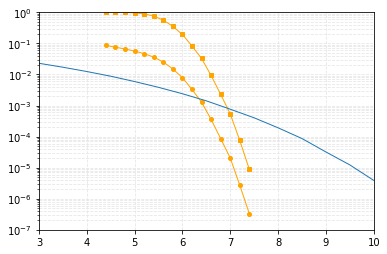

In [35]:
plt.semilogy(db_255_239_17,
                    SER_255_239_17,
                    marker="o",
                    color="orange",
                    markersize=4,
                    lw=1)
plt.semilogy(db_255_239_17,
                    BLER_255_239_17,
                    marker="s",
                    color="orange",
                    markersize=4,
                    lw=1)
plt.semilogy(sim_psk_db, ber_psk, lw=1)
plt.grid(True, which="both", color='0.9', ls="--")
plt.xlim(3, 10.0)
plt.ylim(1e-7, 1)
plt.show()

之后对 RS(255, 223, 33) 的误符号率和误块率进行统计。

In [46]:
db_255_223_33 = np.arange(4.4, 6.8, 0.2)
seq_num_255_223_33 = [20000, 20000, 20000, 20000, 20000, 20000, 20000, 20000, 20000, 50000, 200000, 800000]
amp = EbN02Amp(db_255_223_33, N0, 255, 223)
SER_255_223_33 = np.zeros(db_255_223_33.shape)
BLER_255_223_33 = np.zeros(db_255_223_33.shape)
for index, value in enumerate(amp):
    symbol_num = 0
    block_num = 0
    se_num = 0
    ble_num = 0
    seq_num = 100 * 10 ** ( int(db_255_223_33[index] - 4.0) )
    print("db = ", db_255_223_33[index])
    for k in range(seq_num_255_223_33[index]):
        symbol_seq = np.zeros(255, dtype=np.uint16)
        rec_symbol_seq = np.zeros(255, dtype=np.uint16)
        bit_seq = np.random.randn(255 * 8) * np.sqrt(N0) - value
        for i in range(255):
            symbol = int(0)
            for j in range(8):
                symbol += (1 << j if bit_seq[i * 8 + j] > 0 else 0)
            symbol_seq[i] = symbol
        RS255.berlekamp_decoder(16, symbol_seq, rec_symbol_seq)
        symbol_error_flag = rec_symbol_seq > 0
        block_se_num = np.sum(symbol_error_flag[0:223])
        se_num += block_se_num
        ble_num += ( 1 if block_se_num > 0 else 0 )
        symbol_num += 255
        block_num += 1
        rec_error_num = np.sum(symbol_seq > 0)
        if block_se_num != 0 and rec_error_num <= 16:
            print("error")
    SER_255_223_33[index] = se_num / symbol_num
    BLER_255_223_33[index] = ble_aaa = a['dB']num / block_num
    print("SER: ", SER_255_223_33[index])
    print("BLER: ", BLER_255_223_33[index])
    print()

得到的仿真曲线如下：

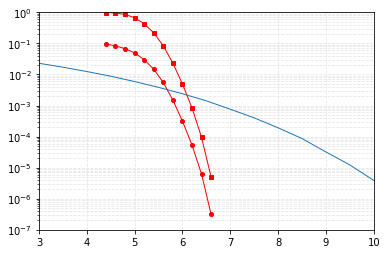

In [8]:
plt.semilogy(db_255_223_33,
                    SER_255_223_33,
                    marker="o",
                    color="r",
                    markersize=4,
                    lw=1)
plt.semilogy(db_255_223_33,
                    BLER_255_223_33,
                    marker="s",
                    color="r",
                    markersize=4,aaa = a['dB']
                    lw=1)
plt.semilogy(sim_psk_db, ber_psk, lw=1)
plt.grid(True, which="both", color='0.9', ls="--")
plt.xlim(3, 10.0)
plt.ylim(1e-7, 1)
plt.show() 

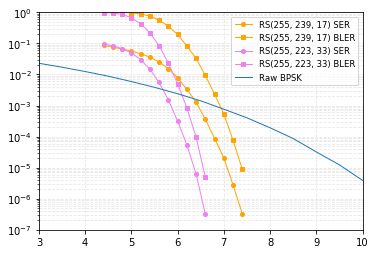

In [36]:
plt.figure(figsize = (5.8, 4))
f1, = plt.semilogy(db_255_239_17,
                            SER_255_239_17,
                            marker="o",
                            color="orange",
                            markersize=4,
                            lw=1)
f2, = plt.semilogy(db_255_239_17,
                            BLER_255_239_17,
                            marker="s",
                            color="orange",
                            markersize=4,
                            lw=1)
f3, = plt.semilogy(db_255_223_33,
                            SER_255_223_33,
                            marker="o",
                            color="violet",
                            markersize=4,
                            lw=1, 
                            label="RS(255, 223, 33) SER")
f4, = plt.semilogy(db_255_223_33,
                            BLER_255_223_33,
                            marker="s",
                            color="violet",
                            markersize=4,
                            lw=1)
f5, = plt.semilogy(sim_psk_db, ber_psk, lw=1)
plt.legend(handles= [f1, f2, f3, f4, f5], 
                 labels = [
                     "RS(255, 239, 17) SER",
                     "RS(255, 239, 17) BLER",
                     "RS(255, 223, 33) SER",
                     "RS(255, 223, 33) BLER", 
                     "Raw BPSK"],
                 loc='best',
                 prop={'size': 8.5})
plt.grid(True, which="both", color='0.9', ls="--")
plt.xlim(3, 10.0)
plt.ylim(1e-7, 1)
plt.show() 

In [37]:
import scipy.io as sio
sio.savemat('RS_255_239_17.mat', {'dB': db_255_239_17,'BLER': BLER_255_239_17,'SER': SER_255_239_17})
sio.savemat('RS_255_223_33.mat', {'dB': db_255_223_33,'BLER': BLER_255_223_33,'SER': SER_255_223_33})

In [38]:
a = sio.loadmat("RS_255_239_17.mat")
b = sio.loadmat("RS_255_223_33.mat")

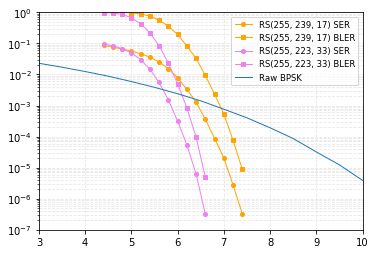

In [43]:
fig = plt.figure(figsize = (5.8, 4))
f1, = plt.semilogy(a['dB'][0, :],
                            a['SER'][0, :],
                            marker="o",
                            color="orange",
                            markersize=4,
                            lw=1)
f2, = plt.semilogy(a['dB'][0, :],
                            a['BLER'][0, :],
                            marker="s",
                            color="orange",
                            markersize=4,
                            lw=1)
f3, = plt.semilogy(b['dB'][0, :],
                            b['SER'][0, :],
                            marker="o",
                            color="violet",
                            markersize=4,
                            lw=1, 
                            label="RS(255, 223, 33) SER")
f4, = plt.semilogy(b['dB'][0, :],
                            b['BLER'][0, :],
                            marker="s",
                            color="violet",
                            markersize=4,
                            lw=1)
f5, = plt.semilogy(sim_psk_db, ber_psk, lw=1)
plt.legend(handles= [f1, f2, f3, f4, f5], 
                 labels = [
                     "RS(255, 239, 17) SER",
                     "RS(255, 239, 17) BLER",
                     "RS(255, 223, 33) SER",
                     "RS(255, 223, 33) BLER", 
                     "Raw BPSK"],
                 loc='best',
                 prop={'size': 8.5})
plt.grid(True, which="both", color='0.9', ls="--")
plt.xlim(3, 10.0)
plt.ylim(1e-7, 1)
fig.savefig('RS255.pdf')
fig.savefig('RS255.png')
fig.savefig('RS255.svg')
plt.show() 